In [1]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [2]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1110889, 20)
         frame_index  res_event_index  res_event_duration
0                  0              0.0                 0.0
1                  1              0.0                 0.0
2                  2              0.0                 0.0
3                  3              0.0                 0.0
4                  4              0.0                 0.0
...              ...              ...                 ...
1110884      1110884              0.0                 0.0
1110885      1110885              0.0                 0.0
1110886      1110886              0.0                 0.0
1110887      1110887              0.0                 0.0
1110888      1110888              0.0                 0.0

[1110889 rows x 3 columns]
1879.0
1.0
825515
825515
[4.14313473 4.14313473 4.14313473 ... 1.09861229 1.09861229 1.09861229]
[1879 1326 1172 1086 1004  979  969  956  936  903  899  844  831  831
  813  810  804  802  799  783]


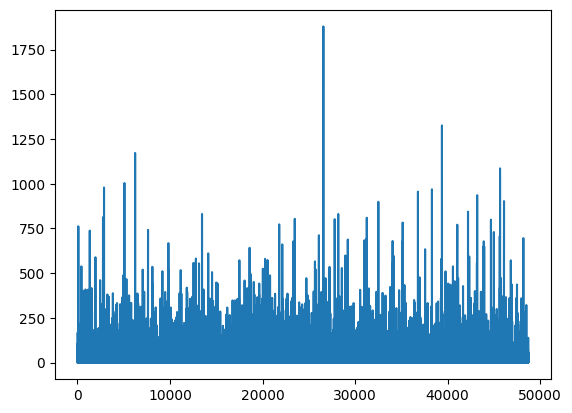

In [3]:
dmat = np.load("distance_matrix_full_FAS.npy")
print(dmat.shape)

events_all = combined_residence_events(dmat)
# mapping = np.zeros(len(events_all))
# avg = np.zeros([len(events_all), len(dmat[0,:])])
# print(avg.shape)
# print(len(events_all))
# print(len(mapping))


# count = 0
# for event in events_all:
#   mapping[count] = len(event)
#   avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
#   count += 1
  
  
mapping = np.zeros(len(dmat[:,0]))
event_index = np.zeros(len(dmat[:,0]))
frame_index = np.arange(len(dmat[:,0]))

count = 0
for event in events_all:
  count += 1
  for i in range(len(event)):
    mapping[event[i]] = len(event)
    event_index[event[i]] = count

dataset_meta = pd.DataFrame({'frame_index': frame_index, 'res_event_index': event_index, 'res_event_duration': mapping})

print(dataset_meta)

todrop = dataset_meta[dataset_meta['res_event_duration'] == 0].index

dmat = np.delete(dmat, todrop, axis=0)
mapping = np.delete(mapping, todrop, axis=0)
logmapping = np.log(mapping)

print(np.max(mapping))
print(np.min(mapping))

print(len(mapping))
print(len(dmat))
print(logmapping)

dmean = np.mean(dmat, 0)
dstd = np.std(dmat, 0)

dmat = (dmat - dmean)/dstd



plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])

# plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])
plt.plot(ploteventsintime)

In [4]:
N = len(logmapping)
test_low = 0
test_high = int(0.25*N)
while(logmapping[test_high] == logmapping[test_high-1]):
  test_high = test_high + 1
print("test frame range", test_low, "to", test_high)
train_low = test_high + 1
train_high = int(0.9*N)
while(logmapping[train_high] == logmapping[train_high-1]):
  train_high = train_high + 1
print("val frame range", train_low, "to", train_high)
val_low = train_high + 1
val_high = len(logmapping) - 1
print("val frame range", val_low, "to", val_high)

test frame range 0 to 206401
val frame range 206402 to 743004
val frame range 743005 to 825514


In [5]:
inputs = torch.from_numpy(dmat)
inputs = torch.tensor(inputs, dtype=torch.float32)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
dataset = TensorDataset(inputs, targets)

N = len(dataset)
indices = np.arange(N)
# indices = np.random.permutation(indices)
test_indices = indices[test_low:test_high]
val_indices = indices[val_low:val_high]
train_indices = indices[train_low:train_high]

print("train indices:")
print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print("val indices:")
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print("test indices:")
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

train indices:
536602
[206402 206403 206404 ... 743001 743002 743003]
val indices:
82509
[743005 743006 743007 ... 825511 825512 825513]
test indices:
206401
[     0      1      2 ... 206398 206399 206400]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_80361/3493379150.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_80361/3493379150.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [7]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            print()
        print()
        
    return model, all_preds, all_labels

In [8]:
trained_model, ap, al = train_model(model, optimizer, num_epochs=2)

Epoch 0/1
----------
train Loss: 1.2245

val Loss: 1.1852


Epoch 1/1
----------
train Loss: 1.1466

val Loss: 1.1515




In [9]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))

al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

tensor(4.3775)
tensor(4.2886)
tensor(123.1278)
tensor(172.3280)


In [10]:
top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])

predicted [[817.83746]] real: [650.0001]
predicted [[806.3722]] real: [650.0001]
predicted [[797.18976]] real: [1085.9998]
predicted [[789.18665]] real: [650.0001]
predicted [[768.9924]] real: [650.0001]
predicted [[762.689]] real: [650.0001]
predicted [[761.3544]] real: [650.0001]
predicted [[752.23285]] real: [1085.9998]
predicted [[751.58716]] real: [1085.9998]
predicted [[749.1948]] real: [1085.9998]
predicted [[744.4159]] real: [650.0001]
predicted [[743.81836]] real: [650.0001]
predicted [[741.8656]] real: [1085.9998]
predicted [[741.1125]] real: [650.0001]
predicted [[740.17834]] real: [650.0001]
predicted [[738.577]] real: [1085.9998]
predicted [[735.0019]] real: [650.0001]
predicted [[734.9339]] real: [650.0001]
predicted [[733.6356]] real: [650.0001]
predicted [[731.30115]] real: [650.0001]


In [13]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [14]:
ap2, al2 = test_model(trained_model)

Test Loss: 1.1345


In [15]:
print(torch.mean(ap2))
print(torch.mean(al2))

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

tensor(4.3293, grad_fn=<MeanBackward0>)
tensor(4.2164)
tensor(112.8737, grad_fn=<MeanBackward0>)
tensor(149.9512)


In [16]:
top = (-ap2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[782.86523]] real: [[668.]]
predicted [[782.4849]] real: [[813.0001]]
predicted [[751.2532]] real: [[668.]]
predicted [[745.99426]] real: [[668.]]
predicted [[745.8954]] real: [[668.]]
predicted [[744.902]] real: [[668.]]
predicted [[742.1872]] real: [[668.]]
predicted [[742.006]] real: [[668.]]
predicted [[733.2404]] real: [[668.]]
predicted [[730.83746]] real: [[668.]]
predicted [[730.3734]] real: [[668.]]
predicted [[729.9469]] real: [[668.]]
predicted [[729.2932]] real: [[668.]]
predicted [[727.88855]] real: [[668.]]
predicted [[726.89343]] real: [[668.]]
predicted [[725.7824]] real: [[668.]]
predicted [[725.74225]] real: [[668.]]
predicted [[724.7141]] real: [[668.]]
predicted [[724.24536]] real: [[668.]]
predicted [[723.2563]] real: [[668.]]


In [17]:
bottom = (ap2).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[2.9621623]] real: [[2.]]
predicted [[2.9733644]] real: [[1.]]
predicted [[2.9760017]] real: [[1.]]
predicted [[2.9791188]] real: [[1.]]
predicted [[2.9832678]] real: [[1.]]
predicted [[2.9912472]] real: [[1.]]
predicted [[2.999958]] real: [[1.]]
predicted [[3.0020208]] real: [[1.]]
predicted [[3.0061245]] real: [[1.]]
predicted [[3.0133207]] real: [[1.]]
predicted [[3.0164847]] real: [[1.]]
predicted [[3.0263724]] real: [[45.000004]]
predicted [[3.027356]] real: [[2.]]
predicted [[3.0409675]] real: [[2.]]
predicted [[3.079045]] real: [[1.]]
predicted [[3.0837564]] real: [[1.]]
predicted [[3.0841515]] real: [[2.]]
predicted [[3.112421]] real: [[2.]]
predicted [[3.1185427]] real: [[6.]]
predicted [[3.1499224]] real: [[1.]]


[1171.9998  1004.0002   979.0002   813.0001   762.0001   742.
  738.       668.       588.99994  537.99994]
1172


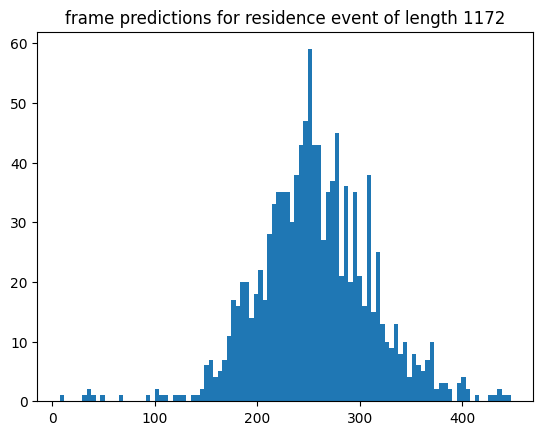

1004


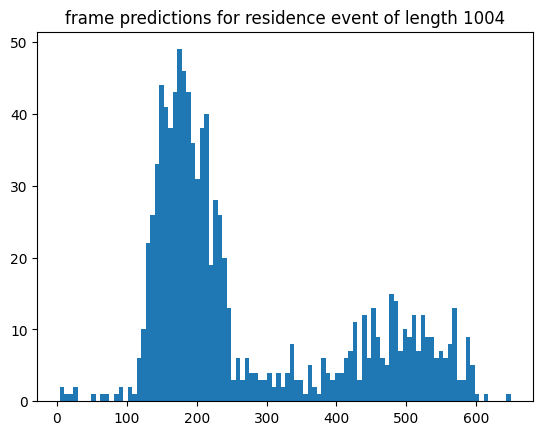

979


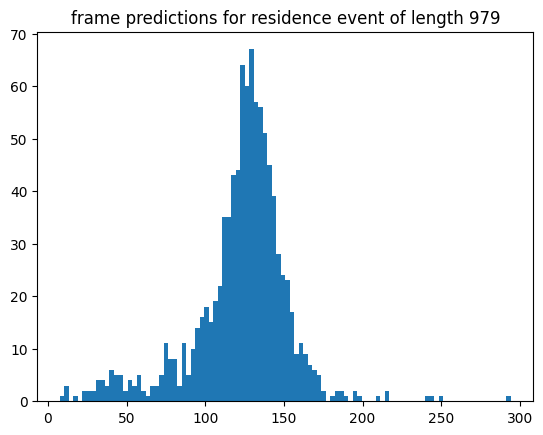

813


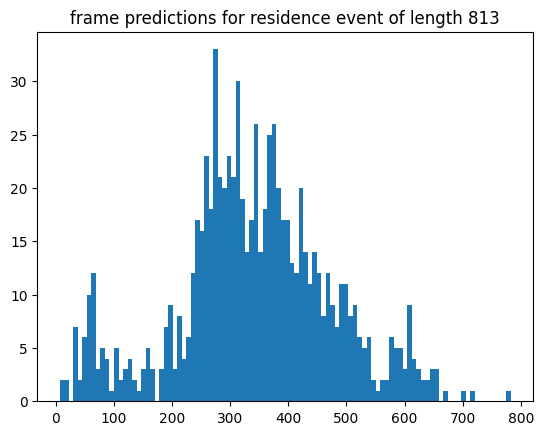

762


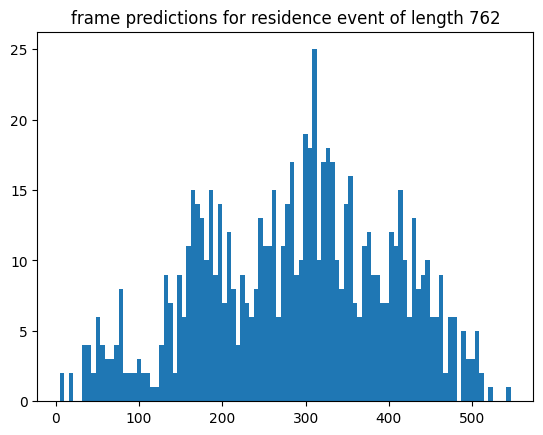

742


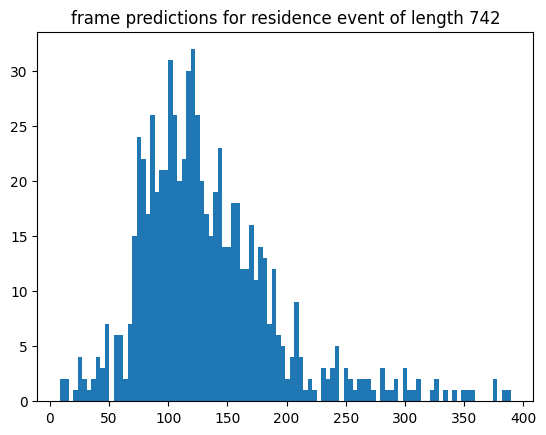

738


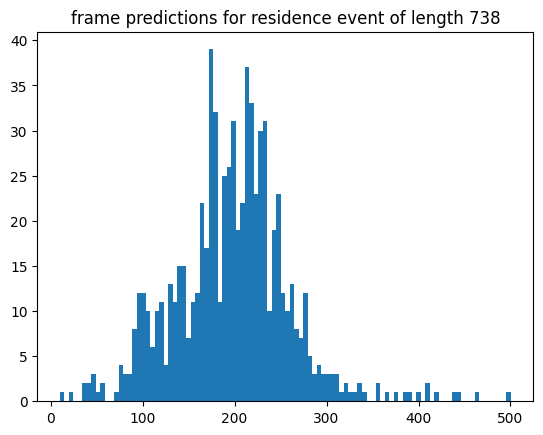

668


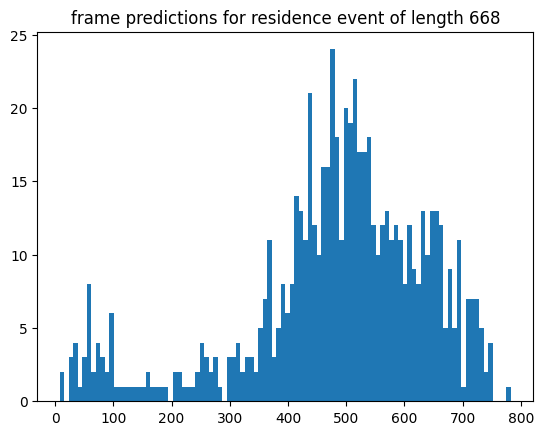

589


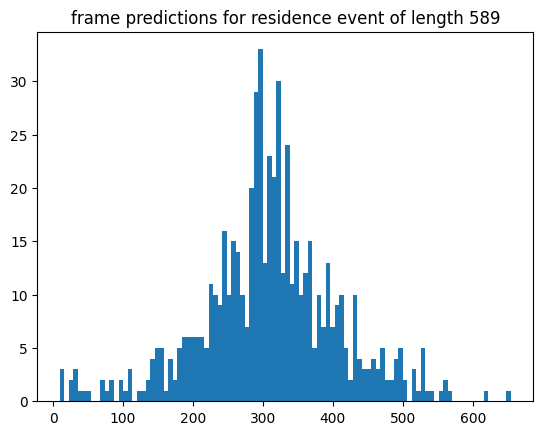

538


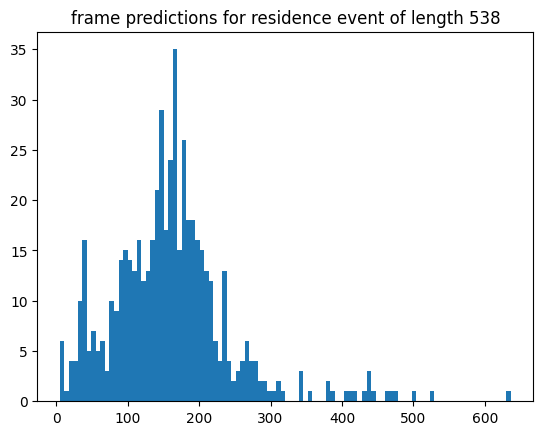

<Figure size 640x480 with 0 Axes>

In [18]:
print(np.sort(np.unique(al2))[::-1][:10])
top_ten = np.sort(np.unique(al2))[::-1][:10]

for i in range(10):
  index = np.where(al2 == top_ten[i])[0]
  preds = ap2[index]
  print(len(preds))

  plt.hist(preds, bins=100)
  plt.title("frame predictions for residence event of length " + str(len(preds)))
  plt.show()
  plt.clf()

r2: 0.5451089468510466


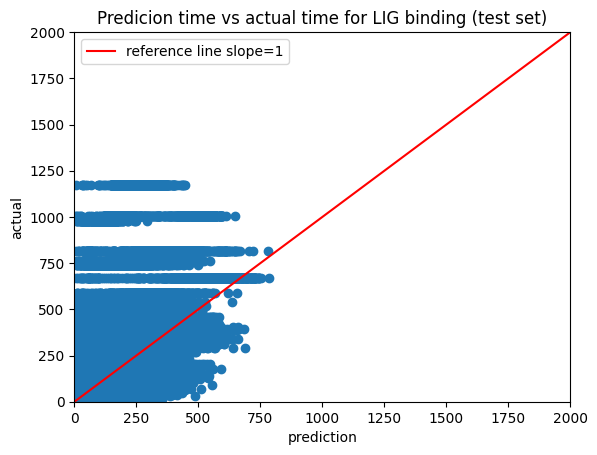

In [19]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 2000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,2000])
plt.xlim([0,2000])
plt.show()

r2: 0.5451089468510466


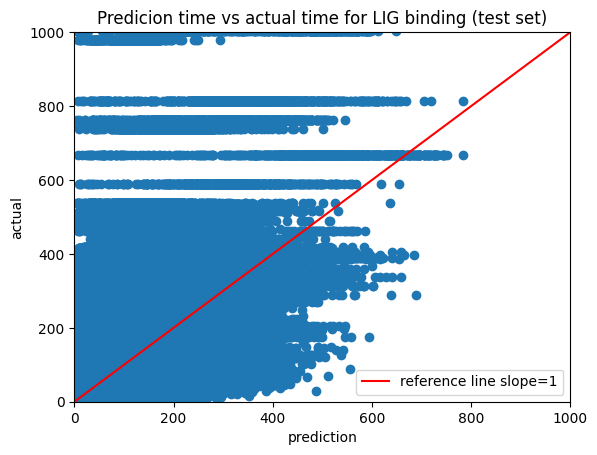

In [20]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 1000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,1000])
plt.xlim([0,1000])
plt.show()

r2: 0.5451089468510466


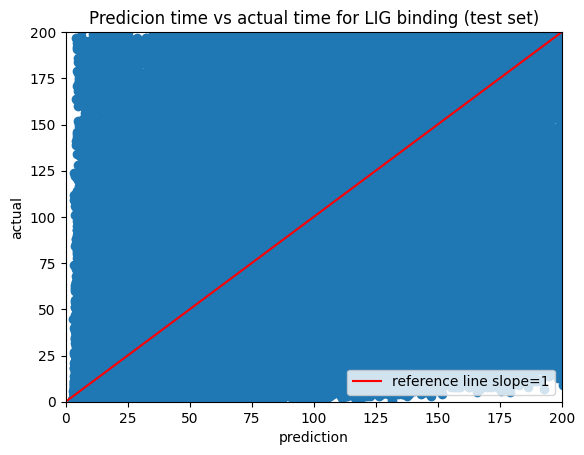

In [21]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 200,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,200])
plt.xlim([0,200])
plt.show()

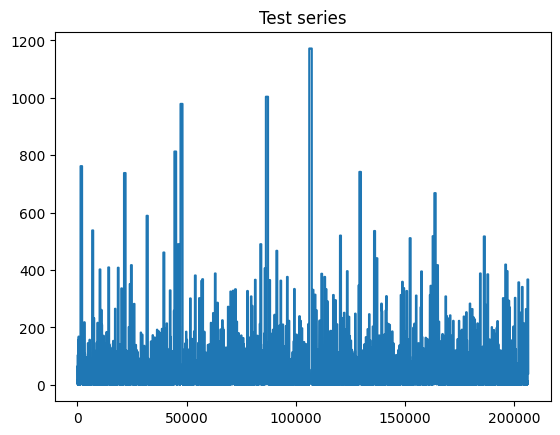

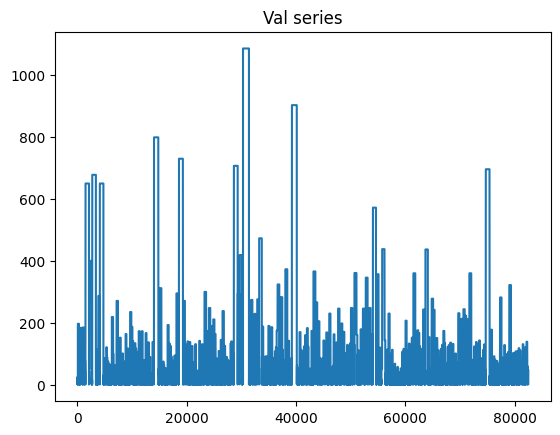

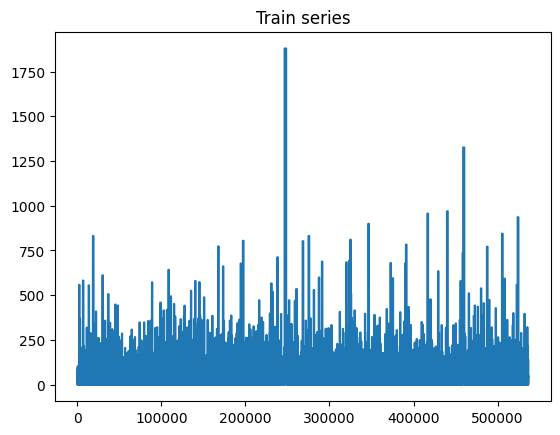

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(mapping[test_low:test_high])
plt.title("Test series")
plt.show()
plt.clf()
plt.plot(mapping[val_low:val_high])
plt.title("Val series")
plt.show()
plt.clf()
plt.plot(mapping[train_low:train_high])
plt.title("Train series")
plt.show()
plt.clf()